### Multiple Jurisdictions ###

With our credible model for dynamic transmission at the contact level and our ability to size environments with approriate contact distributions, we can show the true power of **RKnot** in modelling complex scenarios.

We [have previously shown](load.ipynb#Capacity-Restriction) that contact restrictions and social distancing in any one community *should* be effective in eliminating `sars-cov-2` relatively quickly. Across the world, howvever, many states, provinces, and countries, have experienced second and third waves spaced out months apart despite various forms of strict quarantines and lockdowns.

So why haven't they been effective?

In part, this has resulted from the many exceptions made to these restrictions, in particular, [schools remaining open](load.ipynb#Schools) in many jurisdictions.

We must also consider the impact of multiple jurisdictions that have unique characteristics, set policy independently, and, importantly, allow travel between them.

We will focus on two jurisdictions to start, building to four, and building in complexity along the way.

#### Mixed ####

To start, we will simply double the size of the environment used in [our dynamic transmission risk models](load.ipynb). Thus,

* n = 20,000 and 4 initial infections
* 8 groups, split evenly into two states: "East State" and "West State"
* the states will be exact reflections of each other: 
    * same size, n = 10,000
    * 2 initial infections each
    * same demographic mix
    * same number of events
* the event structrue for each state is detailed in [Sizing](sizing.ipynb#Complex-Environments) (and imported from a pickled object as per below).
* each state will have its own vbox. The `East State` vbox must be reassigned and the events adjusted to point to the correct groups.

```python
from copy import deepcopy

from rknot import Sim, Chart
from rknot.events import Restriction, Quarantine
from rknot.dots.fhutch import tmr
from rknot.sims import us_w_load_18.events

group1 = dict(name='W0-19', n=2700, n_inf=0, ifr=0.00003, mover=.98)
group2 = dict(name='W20-49', n=4100, n_inf=1, ifr=0.0002, mover=.98)
group3 = dict(name='W50-69', n=2300, n_inf=1, ifr=0.005, mover=.98)
group4 = dict(name='W70+', n=900, n_inf=0, ifr=0.054, mover=.98)
wstate = [group1, group2, group3, group4]

wbox = {'label': 'W Main', 'box': 344}
wevents = deepcopy(us_w_load_18.events)
wrsxns = deepcopy(us_w_load_18.rsxns)

group5 = dict(name='E0-19', n=2700, n_inf=0, ifr=0.00003, mover=.98)
group6 = dict(name='E20-49', n=4100, n_inf=1, ifr=0.0002, mover=.98)
group7 = dict(name='E50-69', n=2300, n_inf=1, ifr=0.005, mover=.98)
group8 = dict(name='E70+', n=900, n_inf=0, ifr=0.054, mover=.98)
estate =  [group5, group6, group7, group8]

ebox = {'label': 'E Main', 'box': 344}
eevents = deepcopy(us_w_load_18.events)

for e in eevents:
    e.groups = [4,5,6,7]
    e.vbox = 1

groups = wstate + estate
vboxes = [wbox, ebox]
events = wevents + eevents

params = {
    'groups': groups, 'density': 1, 'days': 365, 'tmr_curve': tmr, 
    'vboxes': vboxes, 'events': events
}

sim = Sim(**params)
sim.run()
```

Below, we show the arrangement of all of the dots mixed throughout the space. The only difference from the single jurisdiction structure is the presence of two vboxes (instead of one).

In [1]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML('multi/mixed_agg_dots_only')))

On a proportionate basis, this structure is indistinguishable from the `n=10,000`, 4 group structure used in the viral load simulations. And it should result in the same outbreak curve, on average.

To test, we ran 50 sims for a quick comparison to the base [Events](load.ipynb#Events) structure that we are building from.

In [8]:
from IPython.core.display import display, HTML

import os
from datetime import datetime as dt
import numpy as np

from rknot.helpers import pickload, find_means, find_seconly, find_means_seconly, get_results
from rknot.notebook import curve_table, md
from rknot.helpers import pickload, ShelfHelp

path = 'vids/multi'
slug = 'mixed-pickled'

file_ = os.path.join(path, slug)
sims = pickload(file_)

last_date = sorted([dt.strptime(date, '%Y-%m-%d') for date in sims.keys()])[-1]
last_date = last_date.strftime('%Y-%m-%d')

res = [get_results(sim) for sim in sims[last_date]['sims']]
res = np.vstack(res)
m = find_means(res)
m_gt0 = find_means_seconly(res, m)

file = 'tests/data/sizing_complex'
key = 'complex_1.8_iters_RESULTS_n_inf_2'

args = []
with ShelfHelp(file, key, no_input=True, load=True) as sh:
    _, _, _, _, res1 = sh.values(*args)
    
m1 = find_means(res1)
m1_gt0 = find_means_seconly(res1, m1)

headers = [r'Mixed<br>$R_0$>0', r'Events w Load<br>$R_0$>0'] 

args = [m_gt0, m1_gt0]
sizes = [(find_seconly(res).shape[0], res.shape[0]), (find_seconly(res1).shape[0], res1.shape[0])]
display(HTML(curve_table(headers, args, sizes)))

As expected, we can see above that, on average, the spread results generated in this structure match those of the [Events structure](load.ipynb#Events) from the viral load analysis. Notice, however, that an outbreak ($R_0$ > 0) occured much more frequently: 56% vs. 27%. This is likely a result of the greater number of initial infections (4 vs. 2).

Also notice that the average Peak is lower and Days to Peak higher in our new scenario despite all other metrics being the same.

We can also see below that the distribution of the Mixed environment is more irregular than the base structure. Outbreaks are sometimes contained to one state and other times hit both states badly and various points in between.

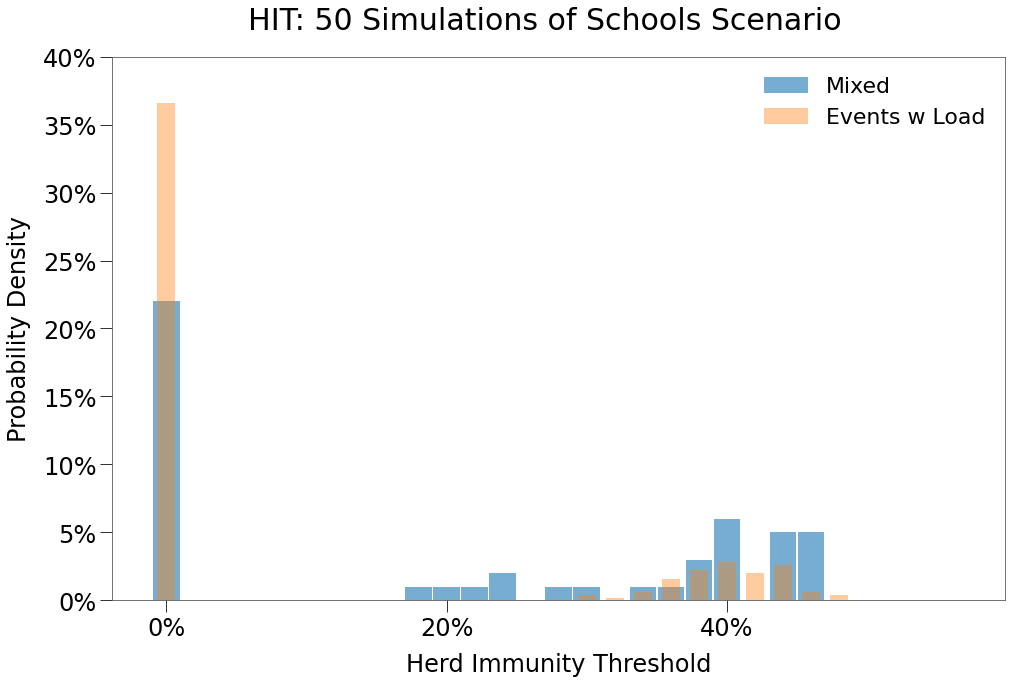

In [40]:
from rknot.notebook import curvehist
savepath = 'vids/multi/mixed_hist'

title = f'HIT: {res.shape[0]} Simulations of Schools Scenario'
labels = ['Mixed', 'Events w Load']
curvehist([res[:,1], res1[:,1]], title=title, which='hit', widths=[.95, .65], labels=labels, savepath=savepath)

We can see this in the sample simulation below:

In [88]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML('multi/mixed_agg')))

Above, we can see a "wave" effect occuring with two peaks forming, the first around 70 days and second around 115 days. We can seperate the curve among the constituent states to see how each state's curve might have added to the aggregate.

In [89]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML('multi/mixed_peaks')))

So, from above, we can see that what looked like a single curve and a single outbreak was, in fact, two outbreaks among the two "states", West and East.

What is remarkable is that the dots from both states are free to mix in the main grid. The separate waves result simply from isolated event spaces where only the largest events (3+ capacity) occur within the state groups.

Next we will show the impact of further isolating the two states.

---
#### Borders ####

Now we will split the environment in two halves, separating the subjects of the West and East States by a border. They cannot interact in any way.

This can be accomplished by simply assign a separate box to the groups in each state, as per below:

```python
for w in wstate:
    w['box'] = {'bounds': [1, 72, 1, 144], 'label': 'West State'}

for e in estate:
    e['box'] = {'bounds': [73, 144, 1, 144], 'label': 'East State'}
    
groups = wstate + estate
params['groups'] = groups
```

This results in the environment shown below:

In [35]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML('multi/split_agg_dots_only')))

We ran 50 simulations to compare with the Mixed environment:

In [34]:
from IPython.core.display import display, HTML

import os
from datetime import datetime as dt
import numpy as np

from rknot.helpers import pickload, find_means, find_seconly, find_means_seconly, get_results
from rknot.notebook import curve_table, md
from rknot.helpers import pickload, ShelfHelp

path = 'vids/multi'
slug = 'split-pickled'

file_ = os.path.join(path, slug)
sims = pickload(file_)

last_date = sorted([dt.strptime(date, '%Y-%m-%d') for date in sims.keys()])[-1]
last_date = last_date.strftime('%Y-%m-%d')

r_spl = [get_results(sim) for sim in sims[last_date]['sims']]

r_spl = np.vstack(r_spl)
m_spl = find_means(r_spl)
m_gt0_spl = find_means_seconly(r_spl, m_spl)

headers = [r'Borders<br>$R_0$>0', r'Mixed<br>$R_0$>0'] 

args = [m_gt0_spl, m_gt0]
sizes = [
    (find_seconly(r_spl).shape[0], r_spl.shape[0]), 
    (find_seconly(res).shape[0], res.shape[0])
]
display(HTML(curve_table(headers, args, sizes)))

We can see:
    
+ an outbreak occurs with about the same frequency; likely b/c both environments have the same number of initial infections
+ the size of the outbreaks is significantly lower in the split environment
+ the peaks are significantly lower in the split environment

In [29]:
from IPython.core.display import display, HTML
from rknot.notebook import make_note

title = 'Contact Mix'
body = 'Importantly, doubling the number of subjects does <em>not</em>'
body += ' change the number of contacts. Instead, it changes'
body += ' <em>who</em> is contacted. And so when the environment'
body += ' is split and the contact mix becomes more heterogeneous, spread is curtailed.'
display(HTML(make_note(title, body)))

Again, we see below that the contact distribution of the Split environment is quite different from the Mixed environment.

In [41]:
from rknot.notebook import curvehist
savepath = 'vids/multi/mixed_hist'

title = f'HIT: {res.shape[0]} Simulations of Schools Scenario'
labels = ['Borders', 'Mixed']
curvehist([r_spl[:,1], res[:,1]], title=title, which='hit', widths=[.95, .65], labels=labels, savepath=savepath)

Here, the same number of outbreaks occur, but the virus cannot cross the border, so at worst can only spread amongst half the population.

Below we see a representative simulation that evidences the border separating the two states. We can see in the grid on the left that the outbreak was entirely isolated to the West state and did *not* seep into the East state at all. This resulted in the shorter, more muted peak.

In [45]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML('multi/split_agg')))

To be continued ...

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [44]:
from rknot.notebook import move_to_doc_folder
move_to_doc_folder('multi.ipynb')